# Experiment Notebook: Validator Revenue and Profit Yields

## Table of Contents
* [Research Question](#Research-Question)
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Revenue and Profit Yields Over Time](#Analysis-1:-Revenue-and-Profit-Yields-Over-Time)
* [Analysis 2: Revenue and Profit Yields Over ETH Staked](#Analysis-2:-Revenue-and-Profit-Yields-Over-ETH-Staked)
* [Analysis 3: Revenue and Profit Yields Over ETH Price](#Analysis-3:-Revenue-and-Profit-Yields-Over-ETH-Price)
* [Analysis 4: Profit Yields Over ETH Staked vs. ETH Price](#Analysis-4:-Profit-Yields-Over-ETH-Staked-vs.-ETH-Price)
* [Analysis 5: Profit Yields By Validator Environment Over Time](#Analysis-5:-Profit-Yields-By-Validator-Environment-Over-Time)

---

# Research Question


# Experiment Summary 

The purpose of this notebook is to 

# Experiment Assumptions

Our model adopts a range of assumptions from the Hoban/Borgers Ethereum 2.0 Economic Model (notably all validator cost assumptions across validator environments).
Since the Hoban/Borgers Model was published pre-Altair and the CADLabs model post-Altair, however, some assumptions differ slightly (notably reward/penalty parameters incl. new sync committee).

See [assumptions document](ASSUMPTIONS.md) for further details.

# Experiment Setup

In [1]:
# 3rd party Python dependencies
import copy
import logging
import numpy as np
import pandas as pd

# Local Python dependencies
import setup
import experiments.notebooks.visualizations as visualizations
import model.constants as constants
from experiments.run import run
from model.types import Stage
from model.system_parameters import validator_environments
from model.state_variables import eth_staked, eth_supply

time: 1.37 s (started: 2021-06-24 10:39:08 +00:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = True

time: 21.8 ms (started: 2021-06-24 10:39:10 +00:00)


In [3]:
# Import the experiment templates
import experiments.templates.time_domain_analysis as time_domain_analysis
import experiments.templates.eth_staked_sweep_analysis as eth_staked_sweep_analysis
import experiments.templates.eth_price_sweep_analysis as eth_price_sweep_analysis
import experiments.templates.eth_price_eth_staked_grid_analysis as eth_price_eth_staked_grid_analysis

time: 1.1 s (started: 2021-06-24 10:39:10 +00:00)


In [4]:
# Inspect an experiment template
visualizations.inspect_module(eth_staked_sweep_analysis)

import numpy as np
import copy

from model.simulation_configuration import TIMESTEPS, DELTA_TIME
from model.state_variables import eth_staked, eth_supply
from experiments.default_experiment import experiment
from model.types import Stage


# Make a copy of the default experiment to avoid mutation
experiment = copy.deepcopy(experiment)

eth_staked_samples = np.linspace(
    eth_staked,
    eth_supply * 0.3,  # 30% of current total ETH supply
    50
)

parameter_overrides = {
    "stage": [Stage.BEACON_CHAIN],
    "eth_staked_process": [
        lambda run, _timestep: eth_staked_samples[run - 1],
    ],
    "eth_price_process": [
        # A sweep of two fixed ETH price points
        lambda _run, _timestep: 100,
        lambda _run, _timestep: 3000,
    ]
}

# Override default experiment parameters
experiment.simulations[0].model.params.update(parameter_overrides)
# Set runs to number of items in eth_staked_samples
experiment.simulations[0].runs = len(eth_staked_samples)
# Run single timestep, set unit of time to multiple epochs
experiment.simulations[0].timesteps = 1
experiment.simulations[0].model.params.update({"dt": [TIMESTEPS * DELTA_TIME]})

time: 106 ms (started: 2021-06-24 10:39:11 +00:00)


In [5]:
# Create copies of the experiment templates
simulation_1 = copy.deepcopy(time_domain_analysis.experiment.simulations[0])
simulation_2 = copy.deepcopy(eth_staked_sweep_analysis.experiment.simulations[0])
simulation_3 = copy.deepcopy(eth_price_sweep_analysis.experiment.simulations[0])
simulation_4 = copy.deepcopy(eth_price_eth_staked_grid_analysis.experiment.simulations[0])
simulation_5 = copy.deepcopy(time_domain_analysis.experiment.simulations[0])

time: 32.5 ms (started: 2021-06-24 10:39:11 +00:00)


Configure the experiments by overriding the default system parameters:

In [6]:
simulation_1.model.params.update({
    'stage': [Stage.BEACON_CHAIN],
    'validator_process': [
        lambda _run, _timestep: 3,  # Current average validators per epoch
        lambda _run, _timestep: 0.5 * 3,  # 50% lower scenario
        lambda _run, _timestep: 1.5 * 3,  # 50% higher scenario
    ]
})

time: 24.8 ms (started: 2021-06-24 10:39:11 +00:00)


In [7]:
simulation_2.model.params.update({})

time: 24.5 ms (started: 2021-06-24 10:39:11 +00:00)


In [8]:
simulation_3.model.params.update({
    'eth_staked_process': [
        lambda _run, _timestep: eth_staked,
        lambda _run, _timestep: min(eth_staked * 2, eth_supply * 0.3),
    ]
})

time: 23.7 ms (started: 2021-06-24 10:39:11 +00:00)


In [9]:
simulation_5.model.params.update({'stage': [Stage.BEACON_CHAIN]})

time: 23.4 ms (started: 2021-06-24 10:39:11 +00:00)


# Analysis 1: Revenue and Profit Yields Over Time

In [10]:
df_1, _exceptions = run(simulation_1)

time: 23.2 s (started: 2021-06-24 10:39:11 +00:00)


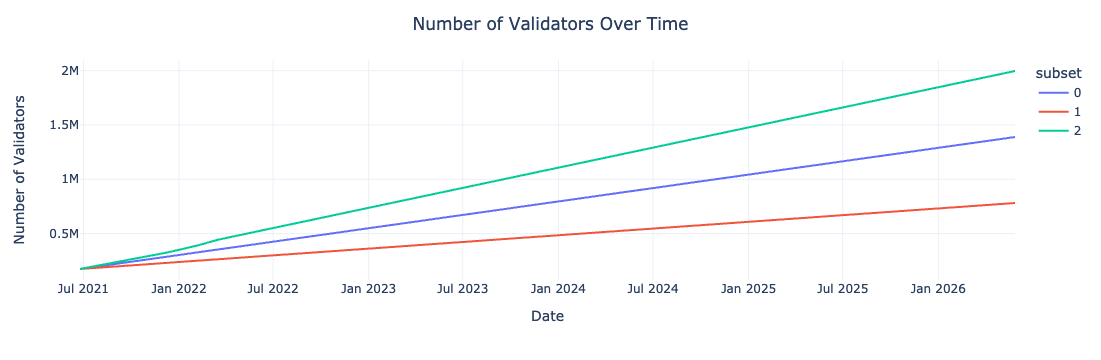

time: 553 ms (started: 2021-06-24 10:39:34 +00:00)


In [11]:
visualizations.plot_number_of_validators_over_time_foreach_subset(df_1)

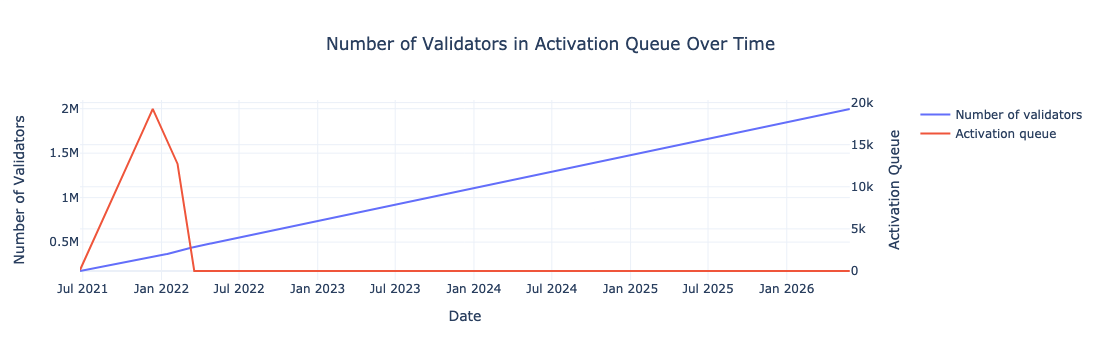

time: 281 ms (started: 2021-06-24 10:39:35 +00:00)


In [12]:
visualizations.plot_number_of_validators_in_activation_queue_over_time(df_1)

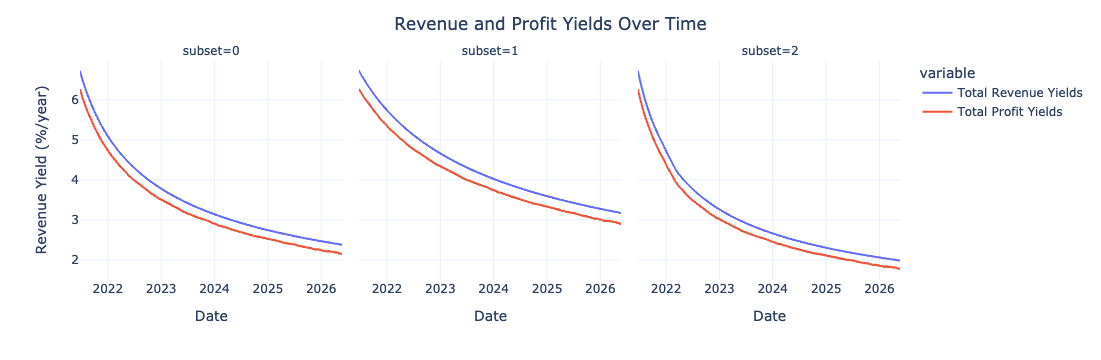

time: 741 ms (started: 2021-06-24 10:39:35 +00:00)


In [13]:
visualizations.plot_revenue_profit_yields_over_time_foreach_subset(df_1)

In [14]:
visualizations.plot_figure_widget_revenue_yields_over_time_foreach_subset(df_1.copy())

time: 367 ms (started: 2021-06-24 10:39:36 +00:00)


In [15]:
rolling_window = df_1.groupby('timestamp')['total_revenue_yields_pct']#.mean().rolling(7)
df_rolling = pd.DataFrame()
df_rolling['rolling_std'] = rolling_window.std()
df_rolling['rolling_mean'] = rolling_window.mean().rolling(7).mean()
df_rolling['min'] = rolling_window.min()
df_rolling['max'] = rolling_window.max()
df_rolling = df_rolling.fillna(0)
df_rolling = df_rolling.reset_index()
df_rolling

timestamp  rolling_std  rolling_mean       min       max
0    2021-06-24 10:39:09.955507     0.004502      0.000000  6.713237  6.721062
1    2021-06-25 10:39:09.955507     0.007825      0.000000  6.697588  6.713237
2    2021-06-26 10:39:09.955507     0.015690      0.000000  6.674032  6.705413
3    2021-06-27 10:39:09.955507     0.023988      0.000000  6.658328  6.705440
4    2021-06-28 10:39:09.955507     0.027535      0.000000  6.642624  6.697507
...                         ...          ...           ...       ...       ...
1795 2026-05-24 10:39:09.955507     0.608262      2.516657  1.986479  3.179946
1796 2026-05-25 10:39:09.955507     0.603969      2.515909  1.986478  3.172086
1797 2026-05-26 10:39:09.955507     0.603971      2.515161  1.986477  3.172088
1798 2026-05-27 10:39:09.955507     0.603973      2.514413  1.986477  3.172091
1799 2026-05-28 10:39:09.955507     0.603973      2.513666  1.986479  3.172094

[1800 rows x 5 columns]

time: 116 ms (started: 2021-06-24 10:39:36 +00:00)


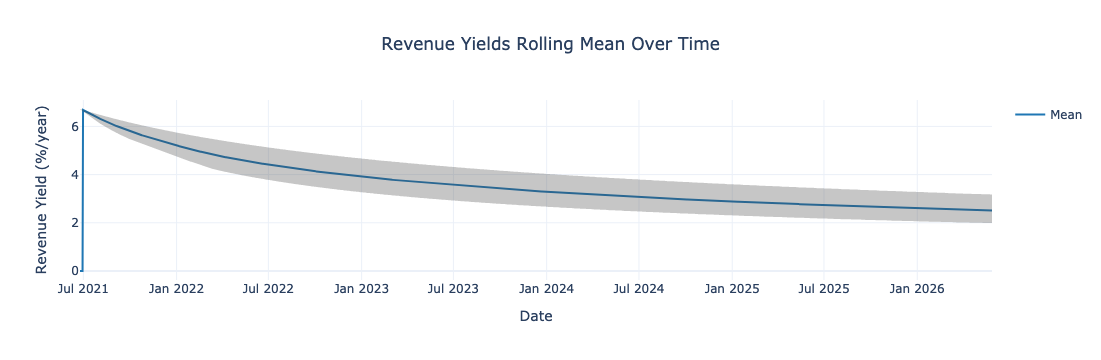

time: 388 ms (started: 2021-06-24 10:39:36 +00:00)


In [16]:
visualizations.plot_revenue_yields_rolling_mean(df_rolling)

# Analysis 2: Revenue and Profit Yields Over ETH Staked

In [17]:
df_2, _exceptions = run(simulation_2)

time: 1.23 s (started: 2021-06-24 10:39:37 +00:00)


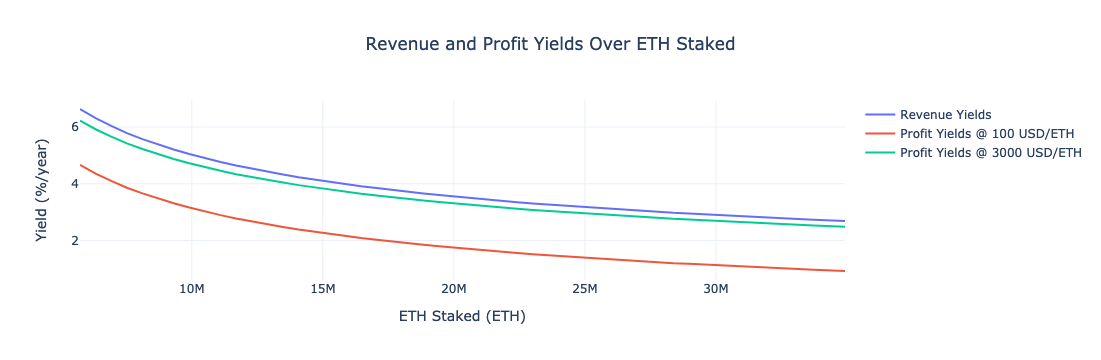

time: 194 ms (started: 2021-06-24 10:39:38 +00:00)


In [18]:
visualizations.plot_revenue_profit_yields_over_eth_staked(df_2)

# Analysis 3: Revenue and Profit Yields Over ETH Price

In [19]:
df_3, _exceptions = run(simulation_3)

time: 1.15 s (started: 2021-06-24 10:39:38 +00:00)


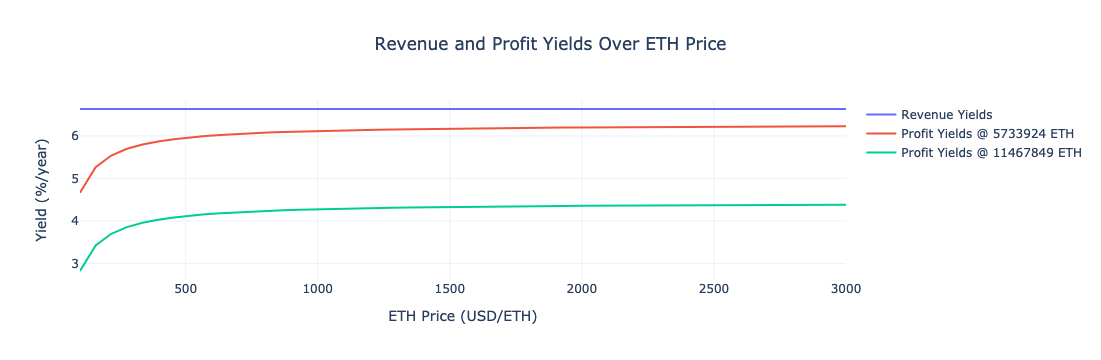

time: 82.6 ms (started: 2021-06-24 10:39:39 +00:00)


In [20]:
visualizations.plot_revenue_profit_yields_over_eth_price(df_3)

# Analysis 4: Profit Yields Over ETH Staked vs. ETH Price

In [21]:
df_4, _exceptions = run(simulation_4)

time: 3.51 s (started: 2021-06-24 10:39:40 +00:00)


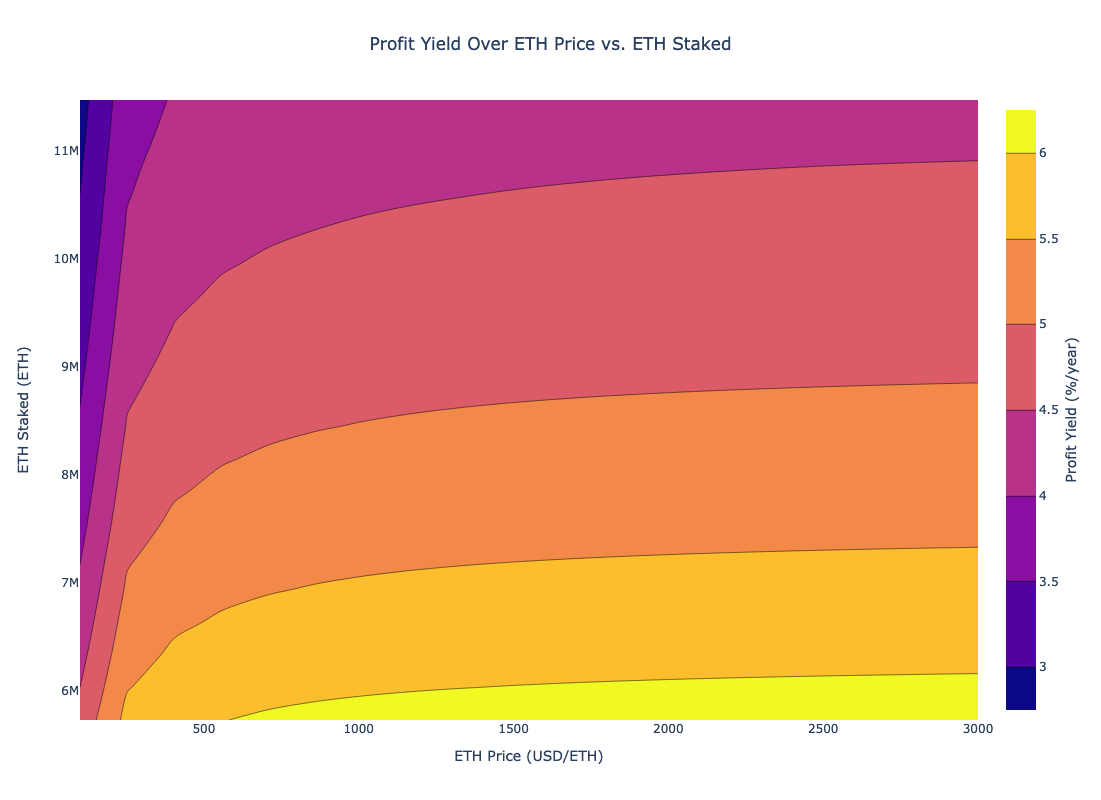

time: 203 ms (started: 2021-06-24 10:39:43 +00:00)


In [22]:
visualizations.plot_validator_environment_yield_contour(df_4)

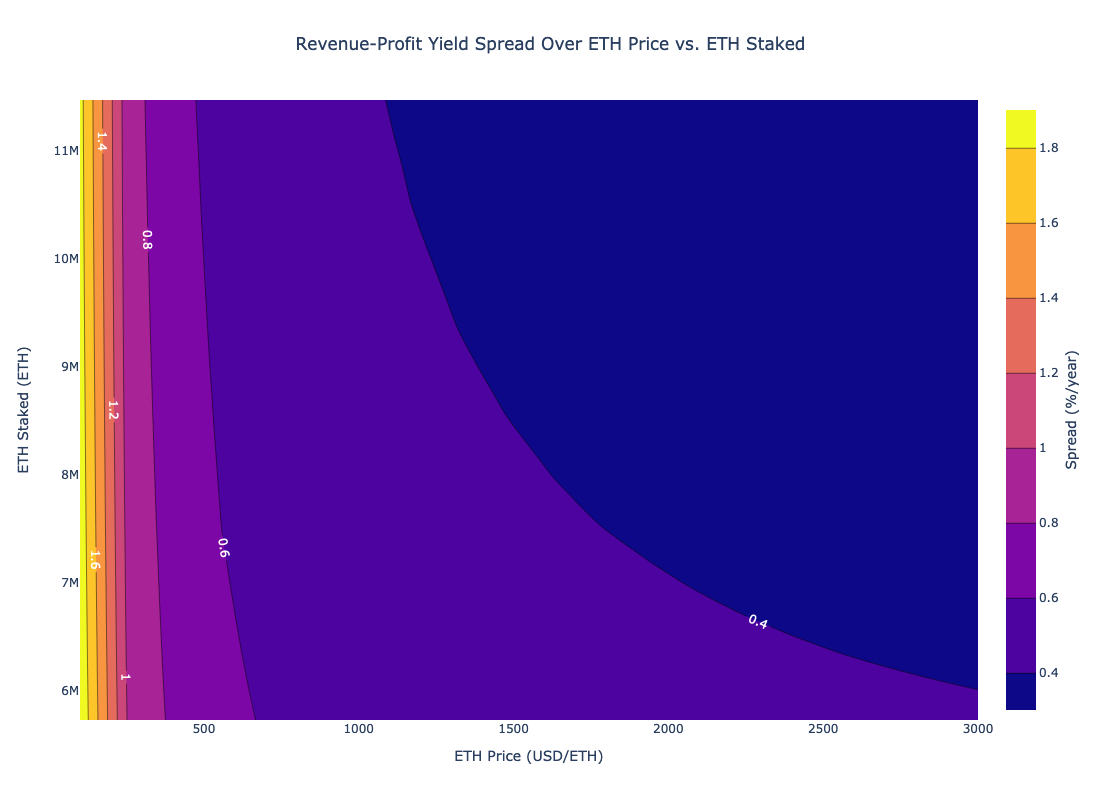

time: 190 ms (started: 2021-06-24 10:39:43 +00:00)


In [23]:
visualizations.plot_revenue_profit_yield_spread(df_4)

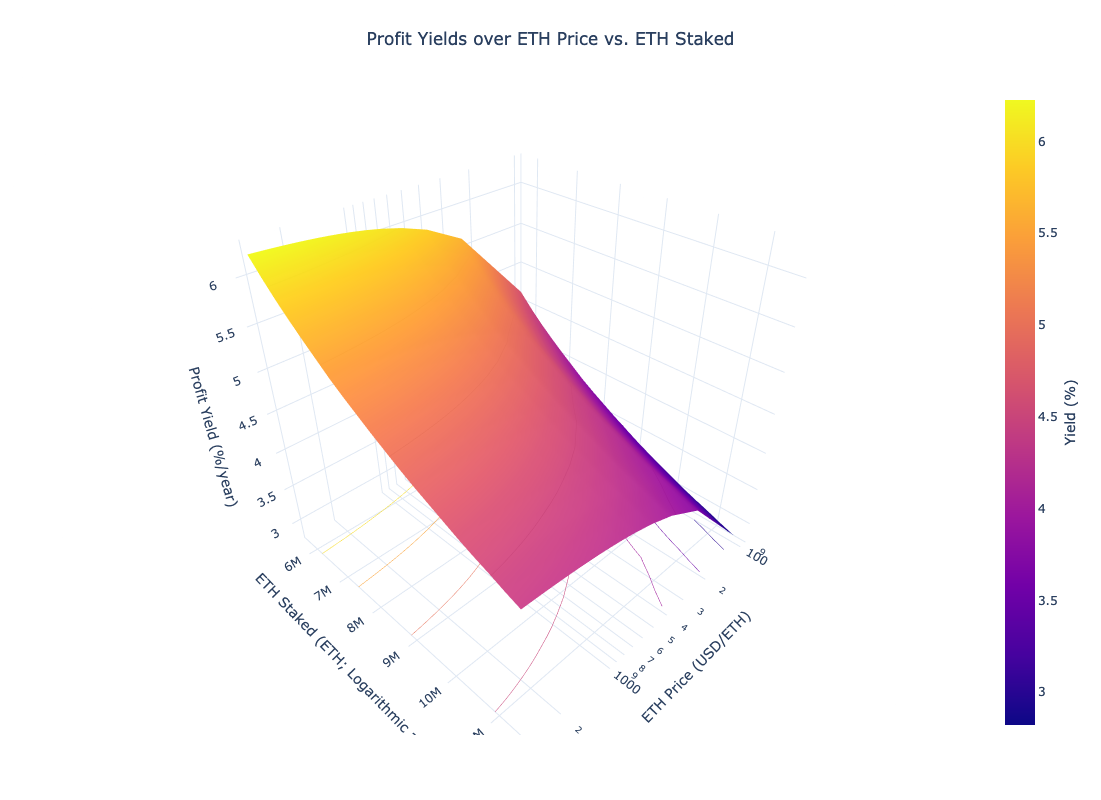

time: 224 ms (started: 2021-06-24 10:39:43 +00:00)


In [24]:
visualizations.plot_validator_environment_yield_surface(df_4)

# Analysis 5: Profit Yields By Validator Environment Over Time

In [25]:
df_5, _exceptions = run(simulation_5)

time: 14.7 s (started: 2021-06-24 10:39:44 +00:00)


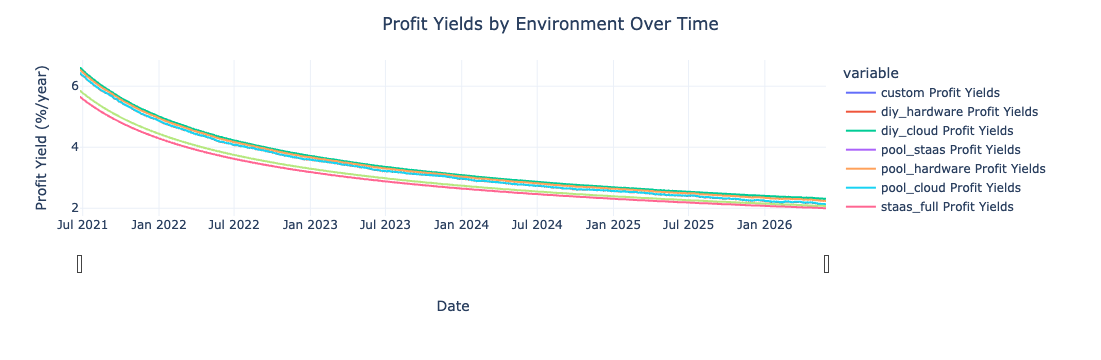

time: 784 ms (started: 2021-06-24 10:39:58 +00:00)


In [26]:
visualizations.plot_profit_yields_by_environment_over_time(df_5)